In [ ]:
!gdown --id 1KVg37Rbhg-4pIHTaAxtGt4BiycrkfwlN
!mkdir breast_cancer_img
!unzip breast-histopathology-images.zip "IDC_regular_ps50_idx5/*" -d breast_cancer_img

Streaming output truncated to the last 5000 lines.
  inflating: breast_cancer_img/IDC_regular_ps50_idx5/9346/0/9346_idx5_x2351_y1551_class0.png  
  inflating: breast_cancer_img/IDC_regular_ps50_idx5/9346/0/9346_idx5_x2351_y1601_class0.png  
  inflating: breast_cancer_img/IDC_regular_ps50_idx5/9346/0/9346_idx5_x2351_y1651_class0.png  
  inflating: breast_cancer_img/IDC_regular_ps50_idx5/9346/0/9346_idx5_x2351_y1701_class0.png  
  inflating: breast_cancer_img/IDC_regular_ps50_idx5/9346/0/9346_idx5_x2351_y1751_class0.png  
  inflating: breast_cancer_img/IDC_regular_ps50_idx5/9346/0/9346_idx5_x2351_y1801_class0.png  
  inflating: breast_cancer_img/IDC_regular_ps50_idx5/9346/0/9346_idx5_x2351_y1851_class0.png  
  inflating: breast_cancer_img/IDC_regular_ps50_idx5/9346/0/9346_idx5_x2351_y1901_class0.png  
  inflating: breast_cancer_img/IDC_regular_ps50_idx5/9346/0/9346_idx5_x2351_y1951_class0.png  
  inflating: breast_cancer_img/IDC_regular_ps50_idx5/9346/0/9346_idx5_x2351_y2001_class0.png  

In [ ]:
from glob import glob # extract all file paths
import numpy as np
import matplotlib.pyplot as plt
from skimage.io import imread
from sklearn.model_selection import train_test_split
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.metrics import f1_score, classification_report
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
files = glob('./breast_cancer_img/IDC_regular_ps50_idx5/*/*/*.png')

In [ ]:
df = pd.DataFrame({'path':files})
df['target'] = df['path'].str.contains('class1').astype('int')
df['id'] = df['path'].apply(lambda x: x.split('/')[3])
df['x'] = df['path'].apply(lambda x: x.split('/')[-1].split('_')[2][1:])
df['y'] = df['path'].apply(lambda x: x.split('/')[-1].split('_')[3][1:])
df['x'] = df['x'].astype(int)
df['y'] = df['y'].astype(int)
df

,path,target,id,x,y
0,./breast_cancer_img/IDC_regular_ps50_idx5/1026...,0,10268,851,1251
1,./breast_cancer_img/IDC_regular_ps50_idx5/1026...,0,10268,201,1351
2,./breast_cancer_img/IDC_regular_ps50_idx5/1026...,0,10268,1001,1601
3,./breast_cancer_img/IDC_regular_ps50_idx5/1026...,0,10268,601,1951
4,./breast_cancer_img/IDC_regular_ps50_idx5/1026...,0,10268,1301,801
...,...,...,...,...,...
277519,./breast_cancer_img/IDC_regular_ps50_idx5/1030...,1,10305,1101,1451
277520,./breast_cancer_img/IDC_regular_ps50_idx5/1030...,1,10305,1101,1551
277521,./breast_cancer_img/IDC_regular_ps50_idx5/1030...,1,10305,1151,1501
277522,./breast_cancer_img/IDC_regular_ps50_idx5/1030...,1,10305,1151,1601


In [ ]:
df['id'].unique().shape

(279,)

In [ ]:
def visualise_breast_tissue(patient_id, pred_df=None):
    example_df = df.loc[df['id']==str(patient_id)]
    max_point = [example_df.y.max()-1, example_df.x.max()-1]
    grid = 255*np.ones(shape = (max_point[0] + 50, max_point[1] + 50, 3)).astype(np.uint8)
    mask = 255*np.ones(shape = (max_point[0] + 50, max_point[1] + 50, 3)).astype(np.uint8)
    if pred_df is not None:
        patient_df = pred_df[pred_df.patient_id == patient_id].copy()
    mask_proba = np.zeros(shape = (max_point[0] + 50, max_point[1] + 50, 1)).astype(np.float)
    
    broken_patches = []
    for n in range(len(example_df)):
        try:
            image = imread(example_df.path.values[n])
            
            target = example_df.target.values[n]
            
            x_coord = np.int(example_df.x.values[n])
            y_coord = np.int(example_df.y.values[n])
            x_start = x_coord - 1
            y_start = y_coord - 1
            x_end = x_start + 50
            y_end = y_start + 50

            grid[y_start:y_end, x_start:x_end] = image
            if target == 1:
                mask[y_start:y_end, x_start:x_end, 0] = 250
                mask[y_start:y_end, x_start:x_end, 1] = 0
                mask[y_start:y_end, x_start:x_end, 2] = 0
            if pred_df is not None:
                
                proba = patient_df[
                    (patient_df.x==x_coord) & (patient_df.y==y_coord)].proba
                mask_proba[y_start:y_end, x_start:x_end, 0] = np.float(proba)

        except ValueError:
            broken_patches.append(example_df.path.values[n])
    
    
    return grid, mask, broken_patches, mask_proba

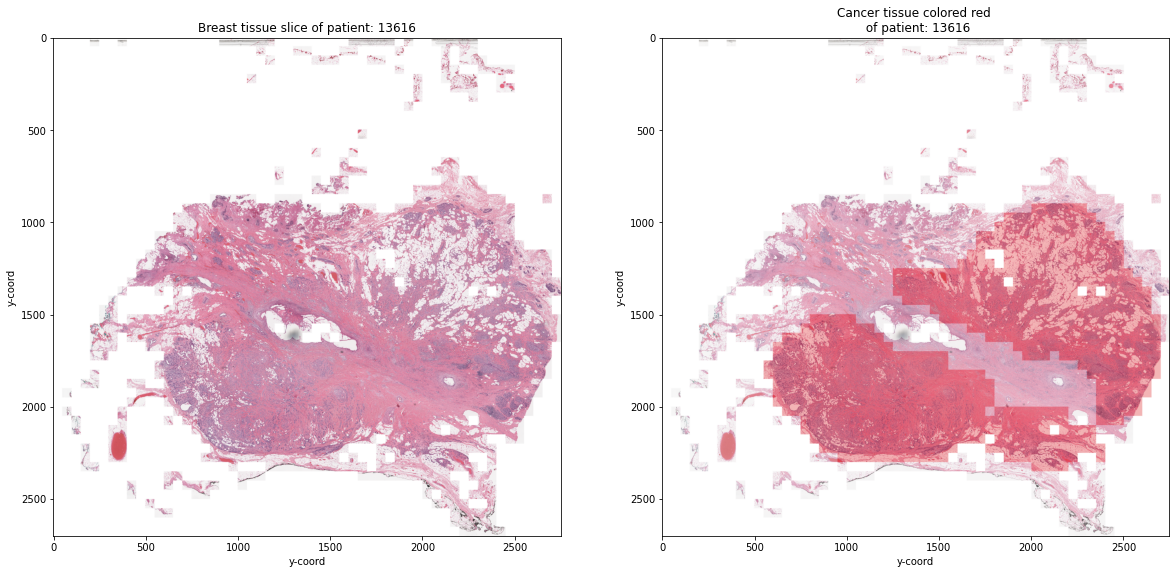

In [ ]:
example = 13616
grid, mask, broken_patches,_ = visualise_breast_tissue(example)

fig, ax = plt.subplots(1,2,figsize=(20,10))
ax[0].imshow(grid, alpha=0.9)
ax[1].imshow(mask, alpha=0.8)
ax[1].imshow(grid, alpha=0.7)
ax[0].grid(False)
ax[1].grid(False)
for m in range(2):
    ax[m].set_xlabel("y-coord")
    ax[m].set_ylabel("y-coord")
ax[0].set_title("Breast tissue slice of patient: " + str(example))
ax[1].set_title("Cancer tissue colored red \n of patient: " + str(example));

In [ ]:
df['target'].value_counts()

0    198738
1     78786
Name: target, dtype: int64

In [ ]:
test_ratio, val_ratio = (0.1,0.1)

In [ ]:
x_train, x_, y_train, y_ = train_test_split(df['path'], df['target'], 
                                            test_size = test_ratio + val_ratio, 
                                            random_state = 42,
                                            stratify = df['target'])

x_val, x_test, y_val, y_test = train_test_split(x_, y_, 
                                                test_size = 0.5, 
                                                random_state = 42,
                                                stratify = y_)

In [ ]:
train_df = pd.DataFrame({'path':x_train,'target':y_train})
val_df   = pd.DataFrame({'path':x_val,'target':y_val})
test_df  = pd.DataFrame({'path':x_test,'target':y_test})

In [ ]:
# do this because tf require str
train_df['target'] = train_df['target'].astype(str)
val_df['target']   = val_df['target'].astype(str)
test_df['target']  = test_df['target'].astype(str)

In [ ]:
# datagen = ImageDataGenerator(rescale=1./255.)
datagen = ImageDataGenerator()

In [ ]:
n_dim = 224 # height/width of expected image
img_size = (n_dim,n_dim)
img_shape = (n_dim,n_dim,3)
batch_size = 64

train_gen = datagen.flow_from_dataframe(train_df,
                                        x_col = 'path',
                                        y_col = 'target',
                                        target_size = img_size, 
                                        class_mode = 'binary',
                                        color_mode = 'rgb',
                                        shuffle = True,
                                        batch_size = batch_size,
                                        validate_filenames = False)

val_gen = datagen.flow_from_dataframe(val_df,
                                      x_col = 'path',
                                      y_col = 'target',
                                      target_size = img_size, 
                                      class_mode = 'binary',
                                      color_mode = 'rgb',
                                      shuffle = False,
                                      batch_size = batch_size,
                                      validate_filenames = False)

test_gen = datagen.flow_from_dataframe(test_df,
                                       x_col = 'path',
                                       y_col = 'target',
                                       target_size = img_size, 
                                       class_mode = 'binary',
                                       color_mode = 'rgb',
                                       shuffle = False,
                                       batch_size = batch_size,
                                       validate_filenames = False)

Found 222019 non-validated image filenames belonging to 2 classes.
Found 27752 non-validated image filenames belonging to 2 classes.
Found 27753 non-validated image filenames belonging to 2 classes.


In [ ]:
# from tensorflow.keras.applications import InceptionResNetV2, MobileNetV2, NASNetMobile
from tensorflow.keras.applications import efficientnet

In [ ]:
# https://keras.io/api/applications/
cnn_base_model = efficientnet.EfficientNetB0(include_top = False, # exclude FC
                             weights = "imagenet", # ~1M pre-trained
                             input_shape = img_shape, 
                             pooling = 'max') # max/avg 
cnn_base_model.trainable=True # False/True

In [ ]:
input_layer = layers.Input(shape = (n_dim, n_dim, 3, ))
input_layer = layers.RandomFlip(mode = "horizontal_and_vertical")(input_layer)
input_layer = layers.RandomRotation(0.2)(input_layer)
cnn_feature = cnn_base_model(input_layer) # vector
output = layers.Dense(1, activation = 'sigmoid')(cnn_feature)

model = keras.Model(inputs = input_layer, outputs = output)
model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4),
              loss = 'binary_crossentropy',
              metrics = ['accuracy'])
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, 1280)             4049571   
                                                                 
 dense_1 (Dense)             (None, 1)                 1281      
                                                                 
Total params: 4,050,852
Trainable params: 4,008,829
Non-trainable params: 42,023
_________________________________________________________________


In [ ]:
earlyStop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience = 3, restore_best_weights=True)

model.fit(train_gen, epochs = 100, callbacks=[earlyStop], validation_data = val_gen, verbose=1)

Epoch 1/100
3470/3470 [==============================] - 3854s 1s/step - loss: 0.3078 - accuracy: 0.8755 - val_loss: 0.2347 - val_accuracy: 0.9040
Epoch 2/100
3470/3470 [==============================] - 3838s 1s/step - loss: 0.2275 - accuracy: 0.9052 - val_loss: 0.2151 - val_accuracy: 0.9134
Epoch 3/100
3470/3470 [==============================] - 3843s 1s/step - loss: 0.1958 - accuracy: 0.9182 - val_loss: 0.2246 - val_accuracy: 0.9088
Epoch 4/100
3470/3470 [==============================] - 3827s 1s/step - loss: 0.1662 - accuracy: 0.9307 - val_loss: 0.2241 - val_accuracy: 0.9160
Epoch 5/100
3470/3470 [==============================] - 3829s 1s/step - loss: 0.1337 - accuracy: 0.9446 - val_loss: 0.2395 - val_accuracy: 0.9129


In [ ]:
model.save_weights('ef.h5')

In [ ]:
y_predicted = model.predict(val_gen, verbose=1)

434/434 [==============================] - 101s 222ms/step


In [ ]:
y_val.values.shape

(27752,)

In [ ]:
threshold_dict = {}
for i in range (1,100):
  y_pred = (y_predicted > (i/100)).astype(int)
  f1_val = f1_score(y_val.values, y_pred, average='macro')
  threshold_dict.update({(i/100) : f1_val})

In [ ]:
threshold_dict

{0.01: 0.663092529874214,
 0.02: 0.7164481002858565,
 0.03: 0.7484279518431172,
 0.04: 0.7704547518453998,
 0.05: 0.7867829210995589,
 0.06: 0.8001761042570743,
 0.07: 0.8099933247604989,
 0.08: 0.8187567921547427,
 0.09: 0.8263273348681003,
 0.1: 0.8328349988822569,
 0.11: 0.8382301462277126,
 0.12: 0.8437571022798825,
 0.13: 0.8478309837946849,
 0.14: 0.8516918870676289,
 0.15: 0.8563890772867093,
 0.16: 0.8606722451156945,
 0.17: 0.8638267232643135,
 0.18: 0.8661903921257574,
 0.19: 0.8687299088699378,
 0.2: 0.8711093625114176,
 0.21: 0.873379125765138,
 0.22: 0.8745840654384572,
 0.23: 0.876757062618973,
 0.24: 0.8781706190079248,
 0.25: 0.8802857471739287,
 0.26: 0.8819273365367706,
 0.27: 0.882990226987247,
 0.28: 0.8847059644130741,
 0.29: 0.8861115867840255,
 0.3: 0.8873261669861409,
 0.31: 0.8882189634820649,
 0.32: 0.8885129673297945,
 0.33: 0.8893625884542609,
 0.34: 0.8898524519200719,
 0.35: 0.8901461952890566,
 0.36: 0.8907483616194707,
 0.37: 0.8916602875523134,
 0.38: 0

In [ ]:
threshold = 0.01
f1_max = 0
for key,value in threshold_dict.items():
  if (value > f1_max):
    f1_max = value
    threshold = key

In [ ]:
f1_max

0.8935784421002932

In [ ]:
threshold

0.41

In [ ]:
y_test_predicted = model.predict(test_gen)

In [ ]:
y_test_predicted = (y_test_predicted > threshold).astype(int)

In [ ]:
print(classification_report(y_test.values, y_test_predicted))

              precision    recall  f1-score   support

           0       0.94      0.94      0.94     19874
           1       0.84      0.85      0.84      7879

    accuracy                           0.91     27753
   macro avg       0.89      0.89      0.89     27753
weighted avg       0.91      0.91      0.91     27753

